# Pipeline Predict
- Download Data
- Load Data
- Analyze trend and cycle
- Transform for stationarity

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller, arma_order_select_ic
from sklearn.model_selection import ParameterGrid
import itertools
import warnings
import seaborn as sns



#Own packages
import download
import descriptive
import models
import model_wrapper

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

# Params to modify

In [9]:
p = range(2, 4)
q = range(2,4)
sea_p = range(0, 2)
sea_q = range(0, 2)
sea_s = [12]
params = {
    'outcome_col': 'iva_neto_(mdp)_r',
    'pred_start': '2016-01-01',
    'pred_end': '2019-07-01',
    'pred_period': '6MS',
    'transformation': 'log_diff',
    'models':{
        'ARIMA': {'order': [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]},
        'SARIMA': {'order': [(x[0], 0, x[1]) for x in list(itertools.product(p, q))],
                   'seasonal_order': [(x[0], 0, x[1], x[2]) for x in list(itertools.product(sea_p, sea_q, sea_s))],
                   'enforce_stationarity': [False],
                   'enforce_invertibility': [False]},
        'ELASTICITY': {'lag_window': [3, 6], 'elasticity': [None, 1.3]},
        'PROPHET': {'seasonality_mode':['additive', 'multiplicative'], 
                    'weekly_seasonality': [False], 
                    'daily_seasonality': [False]}
    }
}

params['outcome_col_transformed'] = params['outcome_col'] + '_' + params['transformation']

## Making model params iterating

In [10]:
all_models_params = {}
for model, specifications in params['models'].items():
    all_models_params[model] = list(ParameterGrid(specifications))    

# Loading data

In [11]:
fiscal_income_df = download.load_fiscal_income()
fiscal_income_df = fiscal_income_df.asfreq(freq='MS')
pib_r_df = download.load_pib_r()
pib_r_2013 = pib_r_df['pibr_2013']

In [12]:
transforms = ['log', 'diff', 'log_diff']
for t in transforms:
    new_serie_name = params['outcome_col'] + '_' + t
    fiscal_income_df[new_serie_name] = descriptive.transformation(fiscal_income_df, params['outcome_col'], t)

# Making Outcome Series

In [13]:
outcome_ts = fiscal_income_df[params['outcome_col']]
outcome_ts_tr = fiscal_income_df[params['outcome_col'] + '_' + params['transformation']]
outcome_ts_tr = outcome_ts_tr[outcome_ts_tr.notna()]

# ARIMA y SARIMA

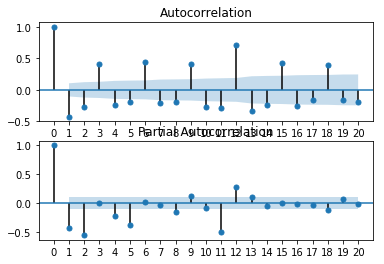

In [8]:
descriptive.plot_acf_pacf(outcome_ts_tr, 20)

### ARIMA Getting best P and Q

In [9]:
arma_order_select_ic(outcome_ts_tr, 3, 3, ic=['aic', 'bic'], trend = 'nc')

{'aic':             0           1           2           3
 0         NaN -334.188569 -332.832467 -352.075900
 1 -207.740693 -332.559168 -340.949986 -354.645513
 2 -336.552841 -347.058904 -363.442171 -438.290861
 3 -334.570210 -362.986568 -369.445162 -446.106035,
 'bic':             0           1           2           3
 0         NaN -326.466996 -321.250108 -336.632755
 1 -200.019121 -320.976810 -325.506841 -335.341582
 2 -324.970482 -331.615759 -344.138240 -415.126144
 3 -319.127065 -343.682637 -346.280445 -419.080532,
 'aic_min_order': (3, 3),
 'bic_min_order': (3, 3)}

In [10]:
pd.date_range(params['pred_start'], params['pred_end'], freq=params['pred_period'])

DatetimeIndex(['2016-01-01', '2016-07-01', '2017-01-01', '2017-07-01',
               '2018-01-01', '2018-07-01', '2019-01-01', '2019-07-01'],
              dtype='datetime64[ns]', freq='6MS')

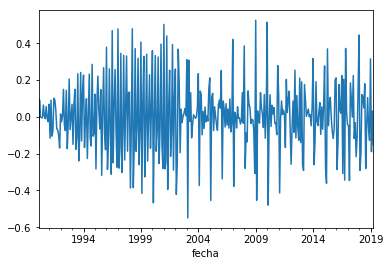

In [11]:
outcome_ts_tr.plot()

ARIMA: order (2, 0, 2), 


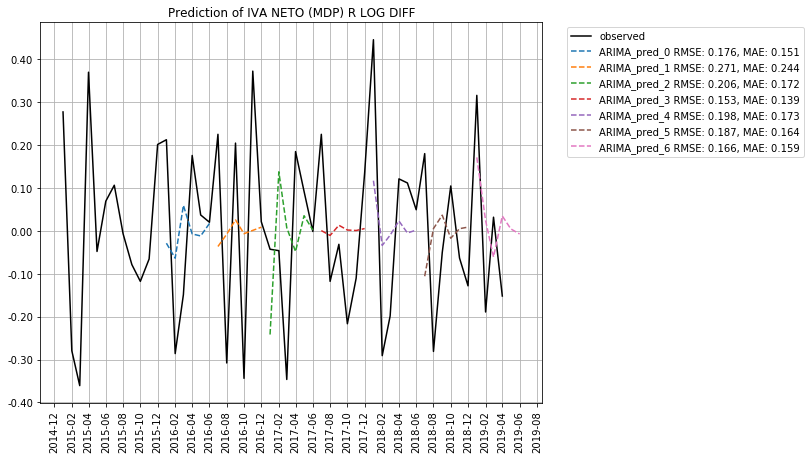

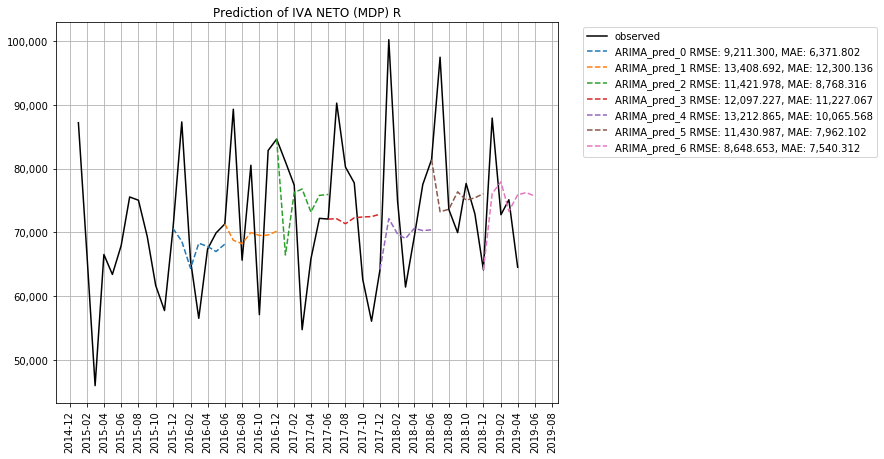

ARIMA: order (2, 0, 3), 


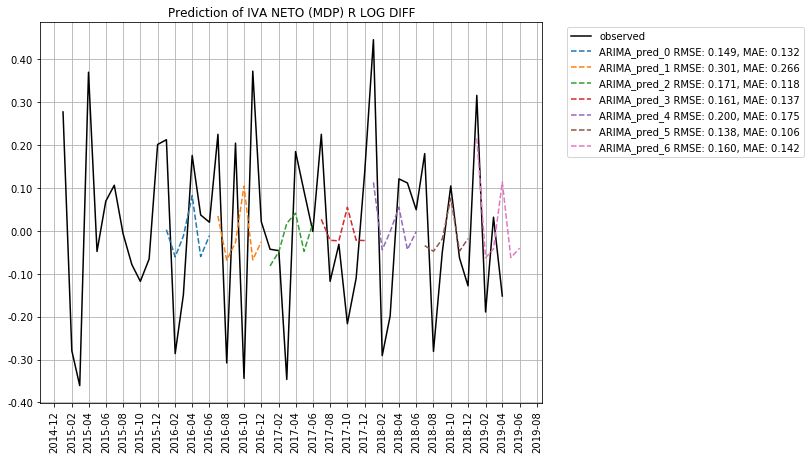

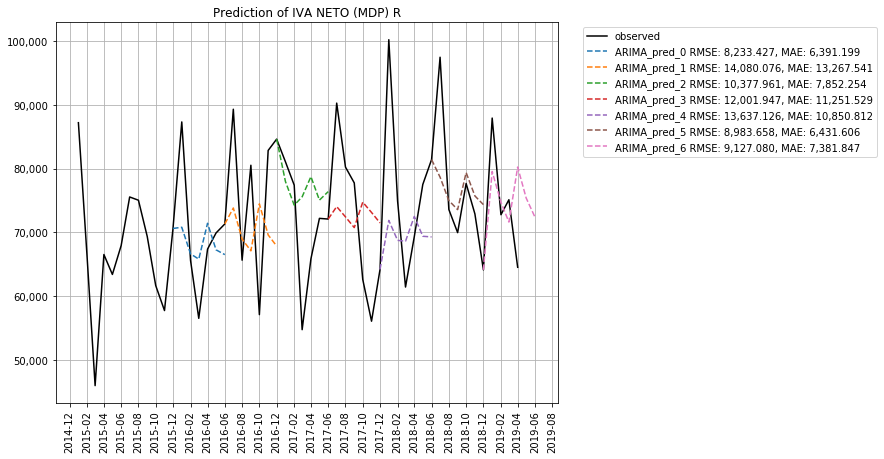

ARIMA: order (3, 0, 2), 


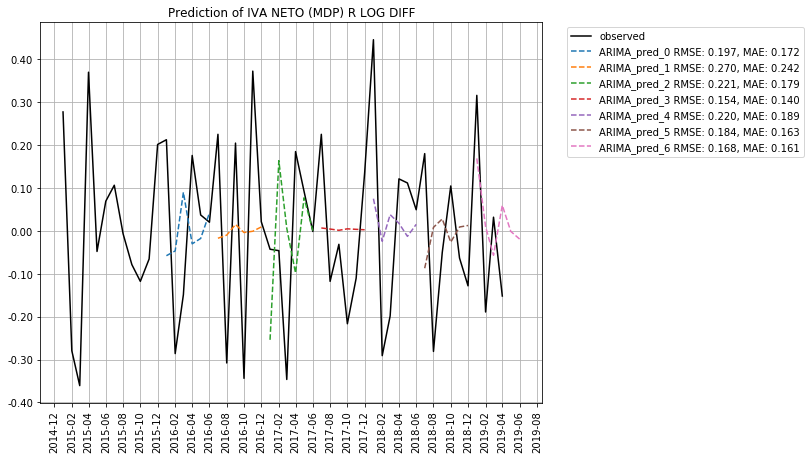

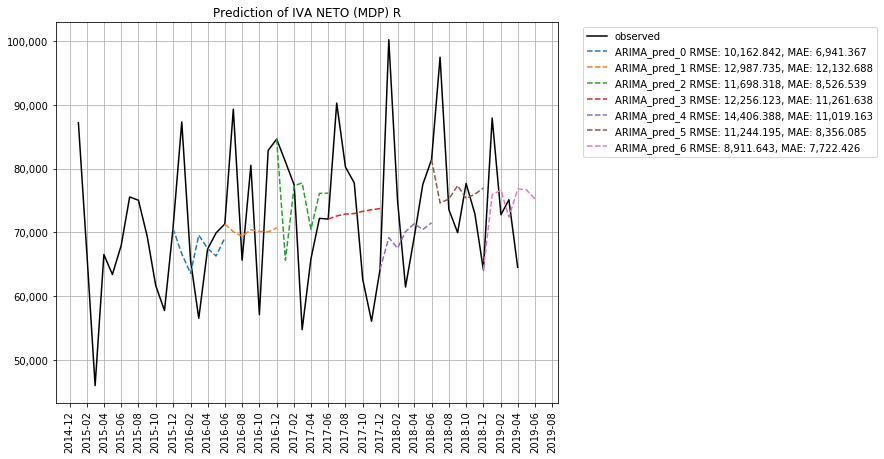

ARIMA: order (3, 0, 3), 


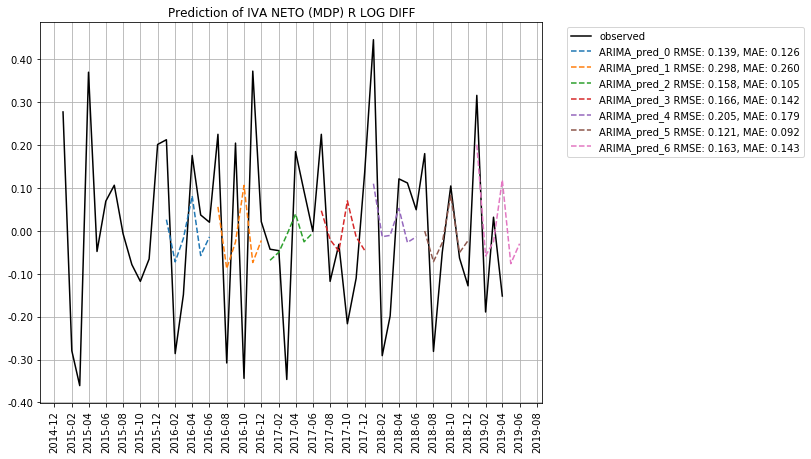

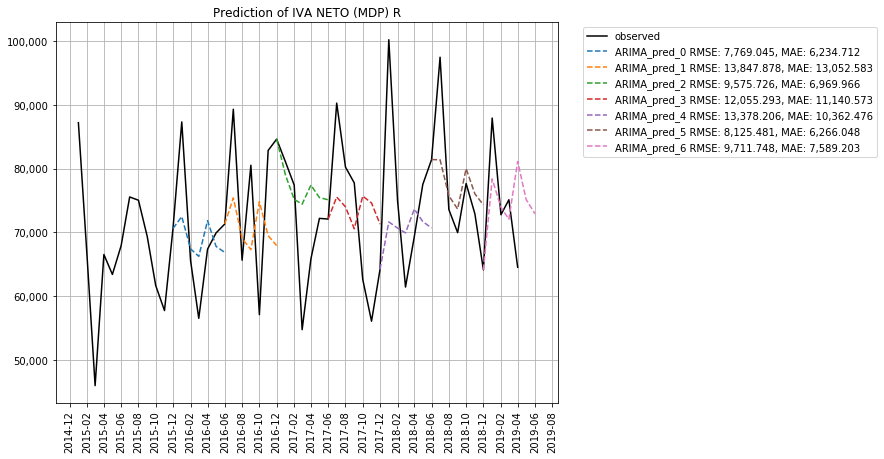

In [12]:
results_arima = models.run_model_joint(model_name='ARIMA', all_models_params=all_models_params,
                                       outcome_var=outcome_ts, global_params=params, plot_extra=True,
                                       outcome_var_tr=outcome_ts_tr)

## SARIMA Getting best P, Q and S

In [13]:
sarima_aic = {'param':[], 'aic':[]}
for param in all_models_params['SARIMA']:
    mod = sm.tsa.statespace.SARIMAX(outcome_ts_tr, **param)
    results = mod.fit(maxiter=200)
    sarima_aic['param'].append(param)
    sarima_aic['aic'].append(results.aic)
sarima_aic = pd.DataFrame(sarima_aic)
sarima_aic = sarima_aic.sort_values('aic')
with pd.option_context("display.max_rows", 999):
    print(sarima_aic.head().values)

[[{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (3, 0, 3), 'seasonal_order': (1, 0, 1, 12)}
  -520.9396001490662]
 [{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 3), 'seasonal_order': (1, 0, 1, 12)}
  -516.1060958143275]
 [{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (3, 0, 2), 'seasonal_order': (1, 0, 1, 12)}
  -512.4204217309435]
 [{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 2), 'seasonal_order': (1, 0, 1, 12)}
  -508.189452177372]
 [{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (3, 0, 3), 'seasonal_order': (1, 0, 0, 12)}
  -495.9899694771864]]


SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 2), seasonal_order (0, 0, 0, 12), 


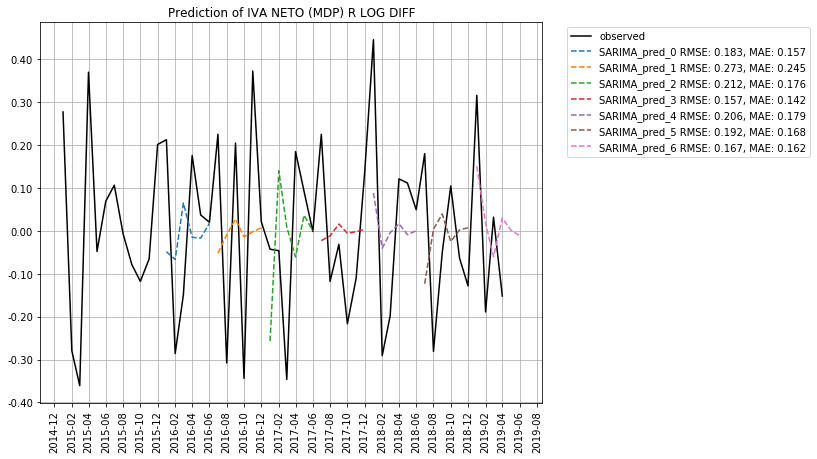

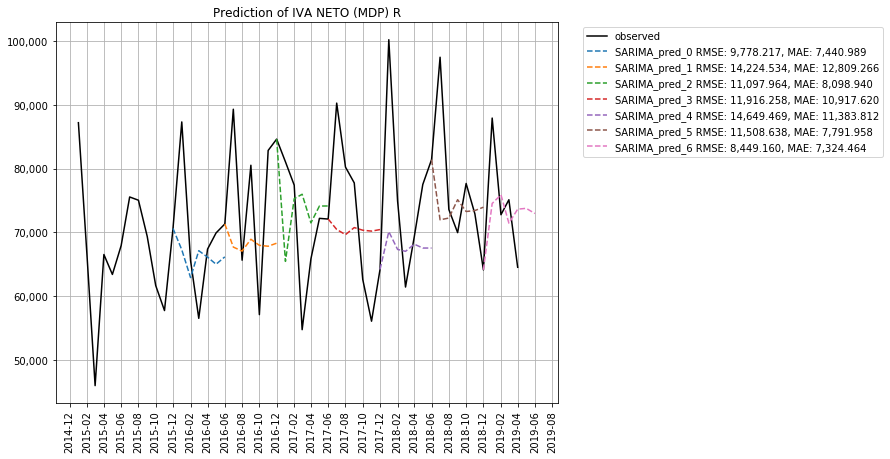

SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 2), seasonal_order (0, 0, 1, 12), 


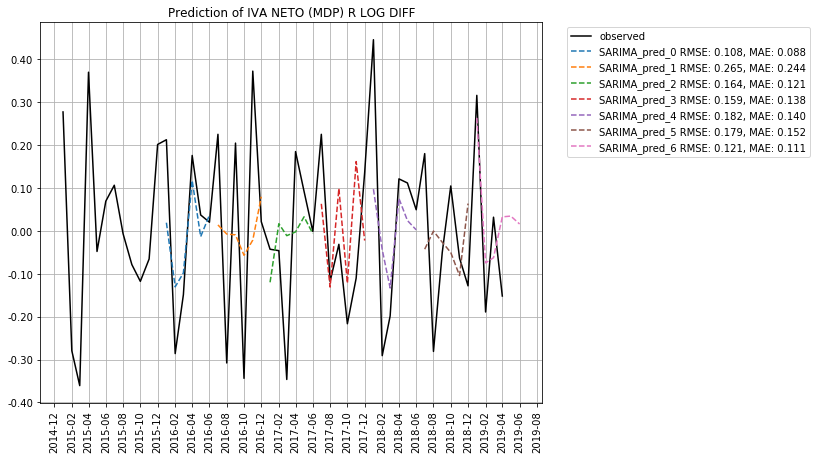

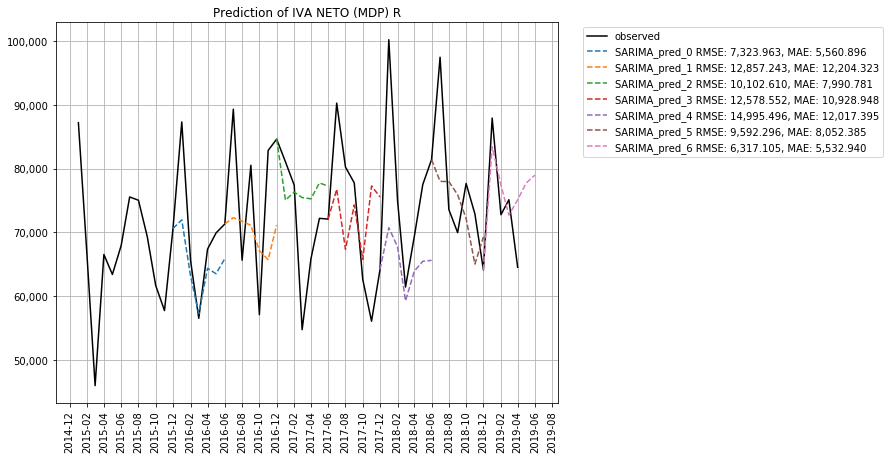

SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 2), seasonal_order (1, 0, 0, 12), 


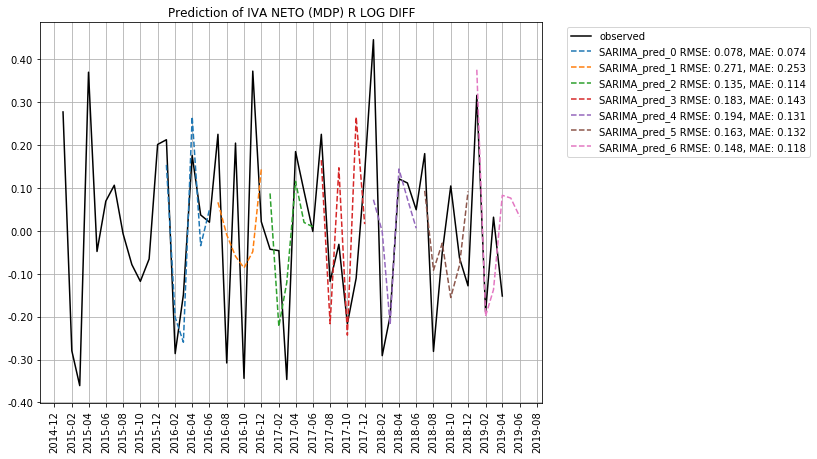

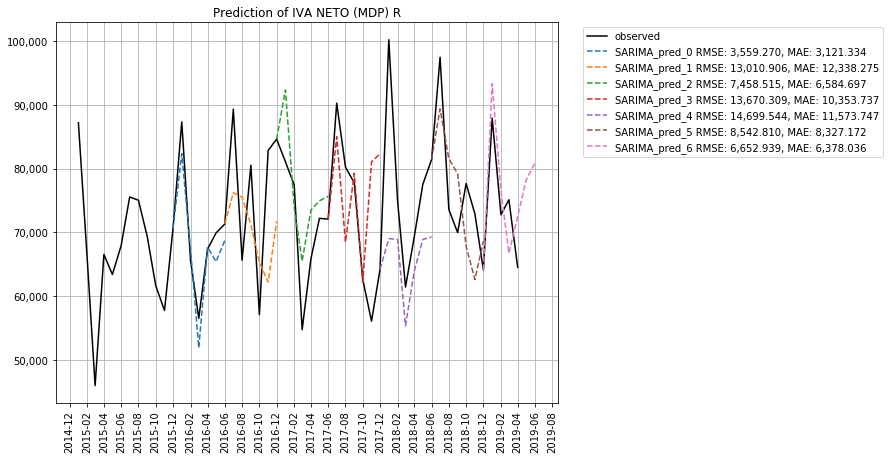

SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 2), seasonal_order (1, 0, 1, 12), 


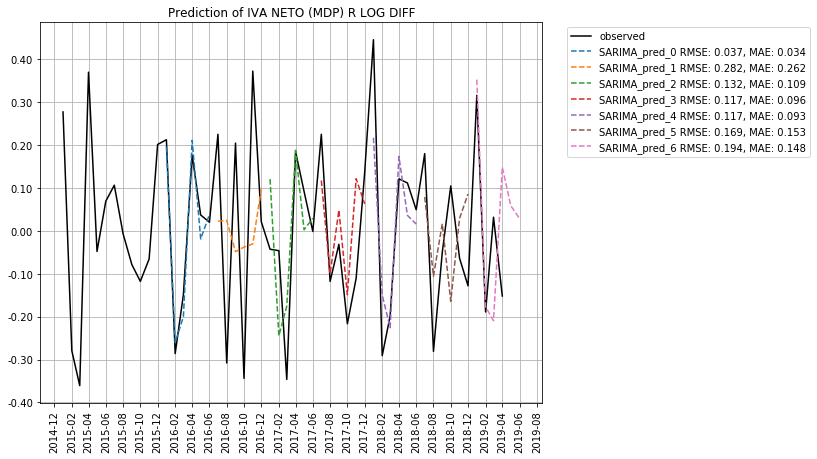

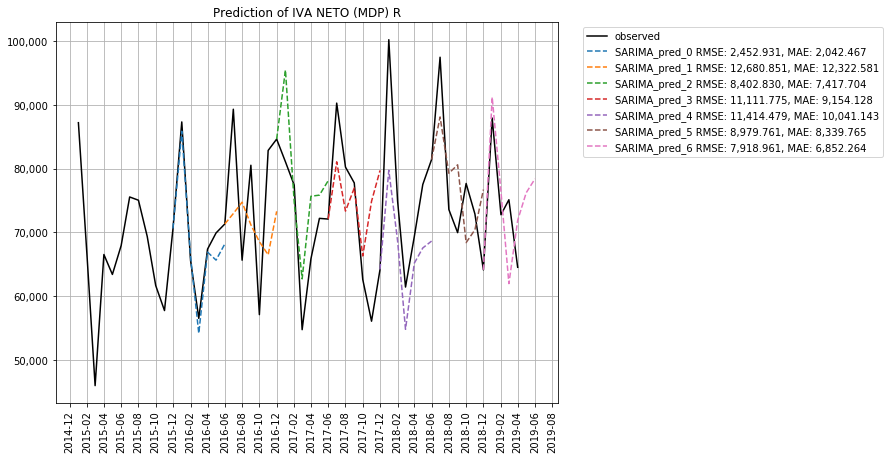

SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 3), seasonal_order (0, 0, 0, 12), 


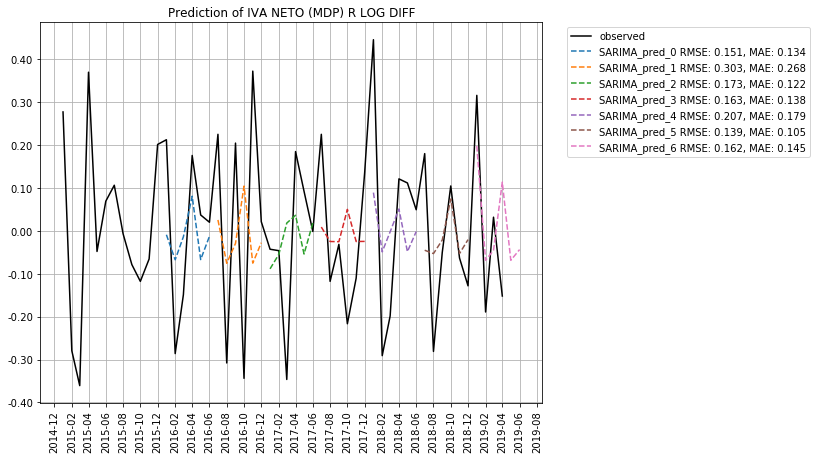

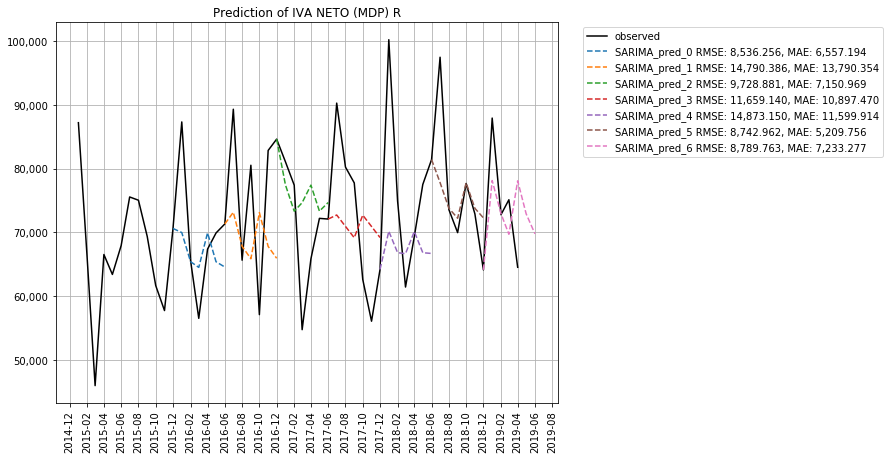

SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 3), seasonal_order (0, 0, 1, 12), 


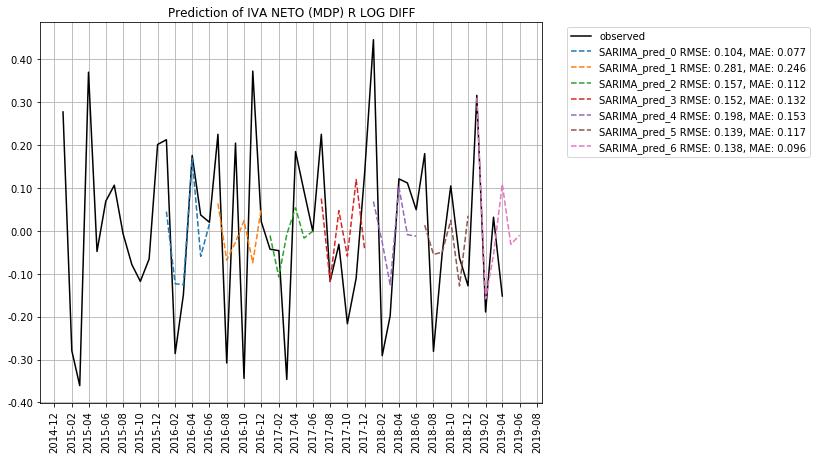

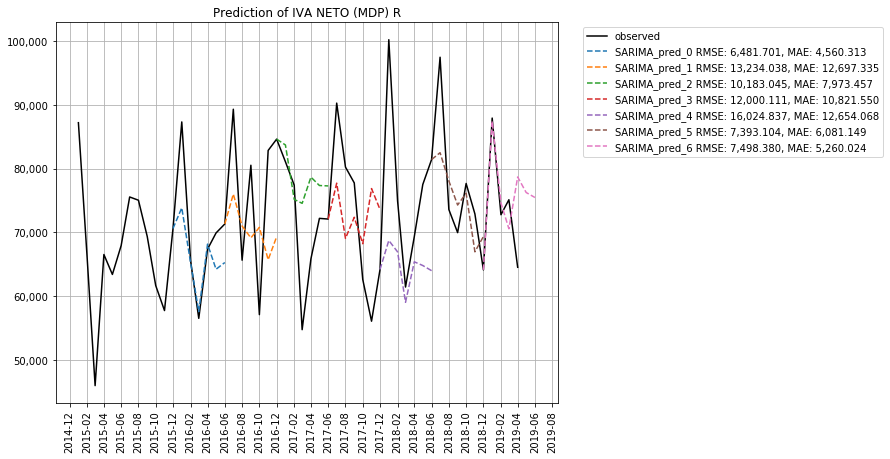

SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 3), seasonal_order (1, 0, 0, 12), 


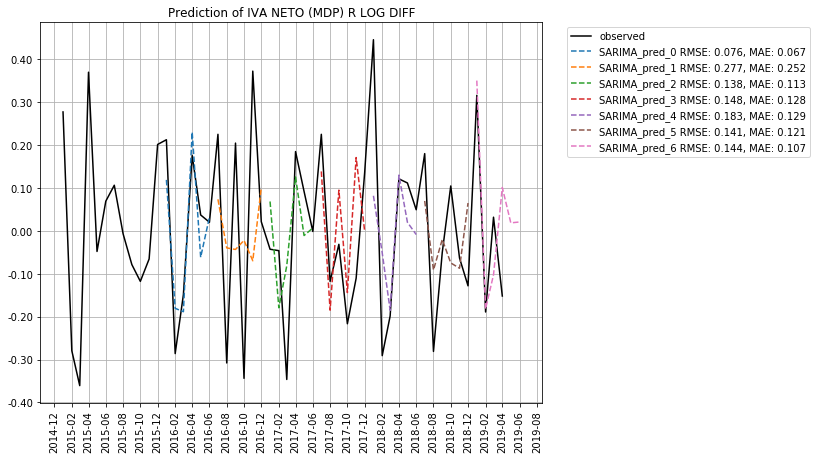

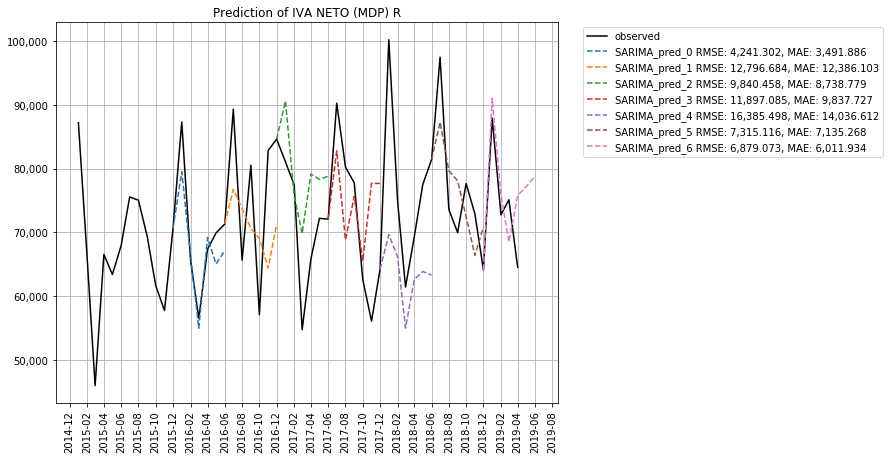

SARIMA: enforce_invertibility False, enforce_stationarity False, order (2, 0, 3), seasonal_order (1, 0, 1, 12), 


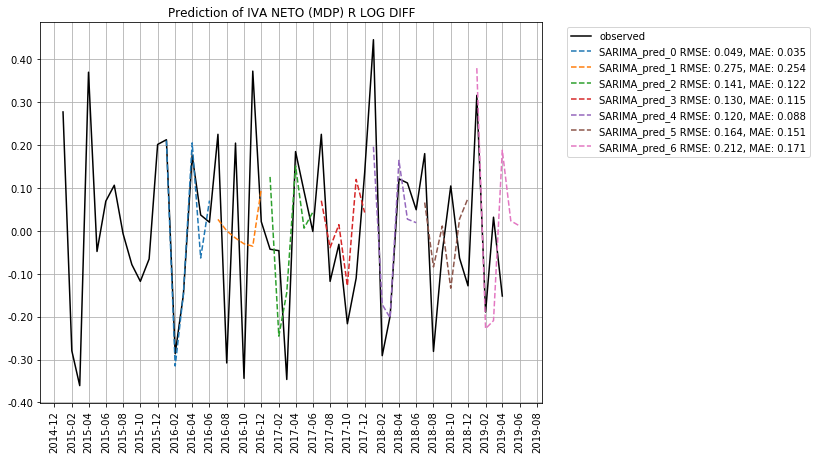

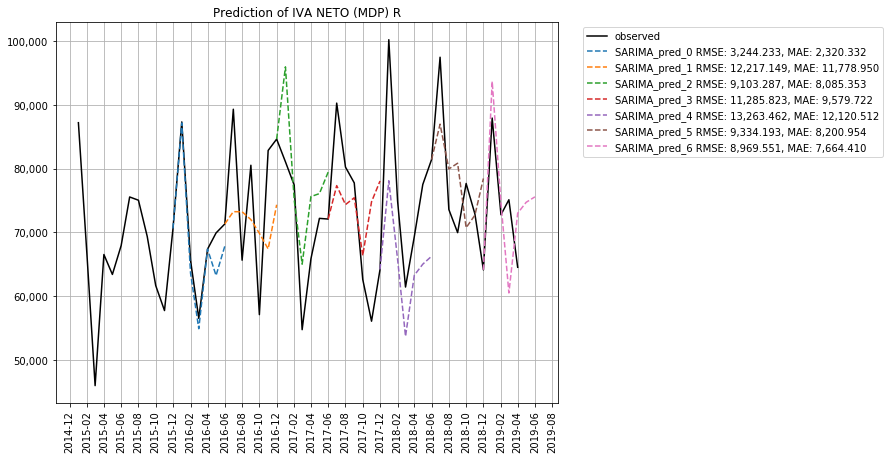

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 2), seasonal_order (0, 0, 0, 12), 


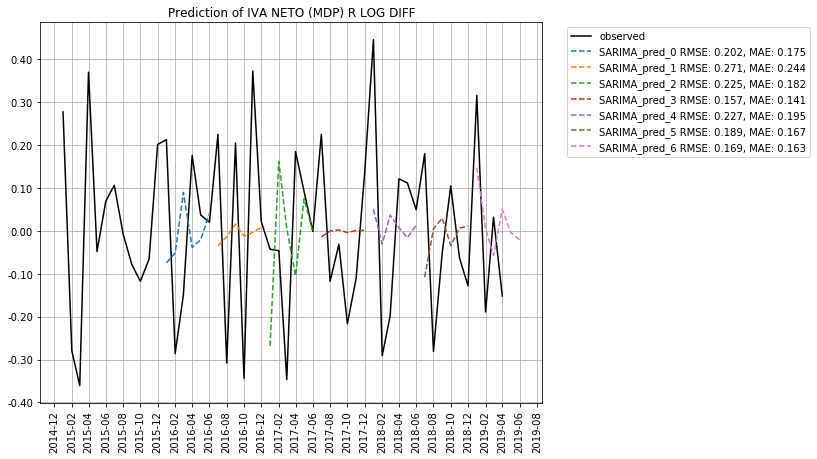

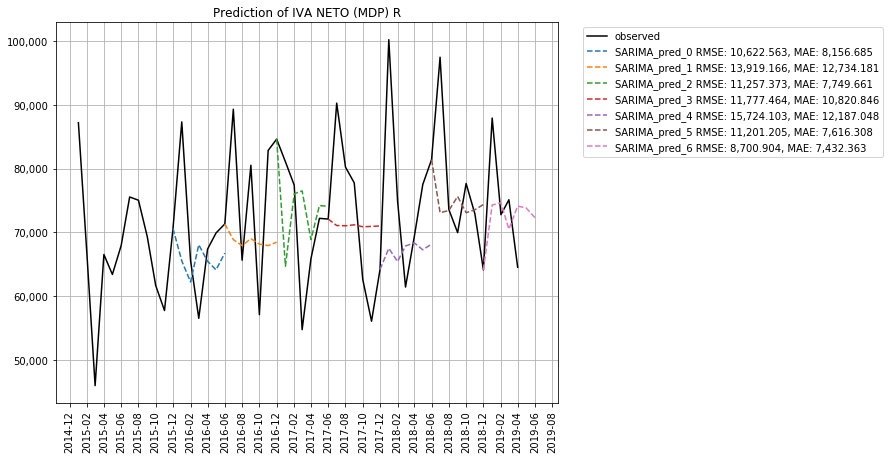

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 2), seasonal_order (0, 0, 1, 12), 


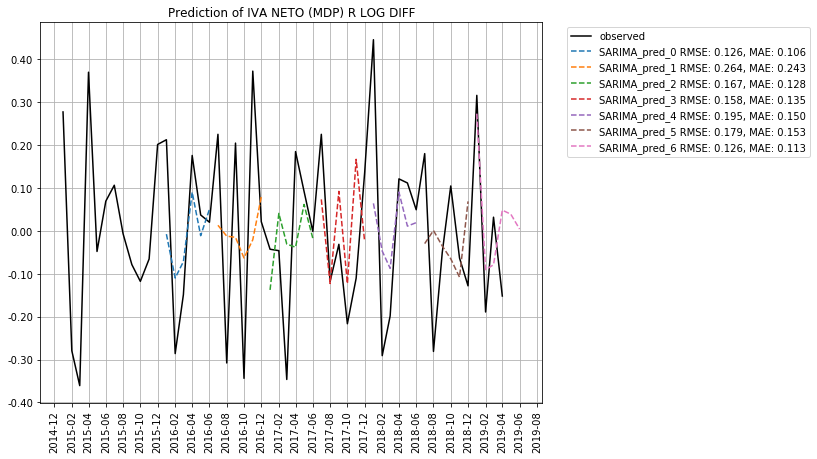

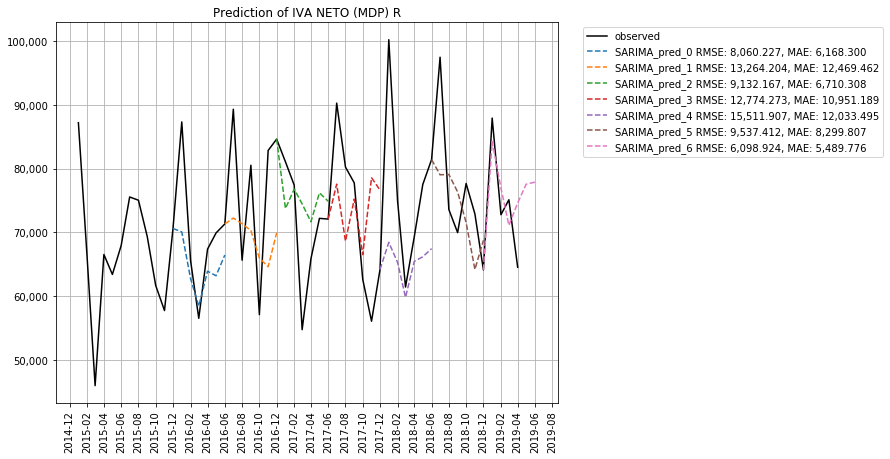

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 2), seasonal_order (1, 0, 0, 12), 


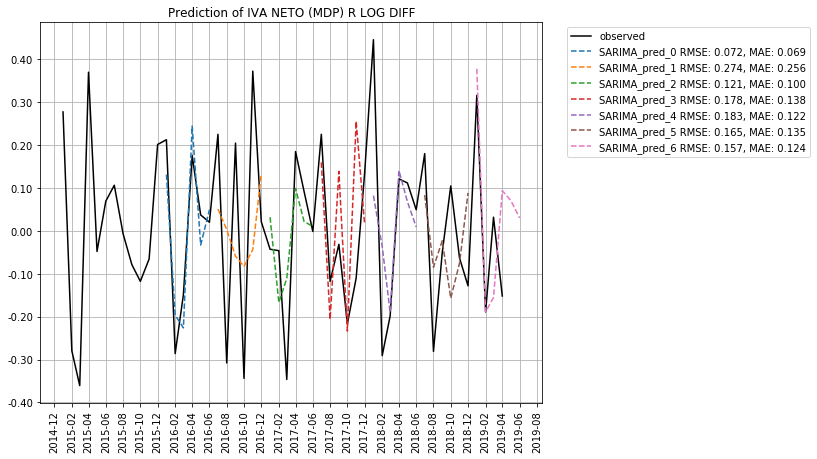

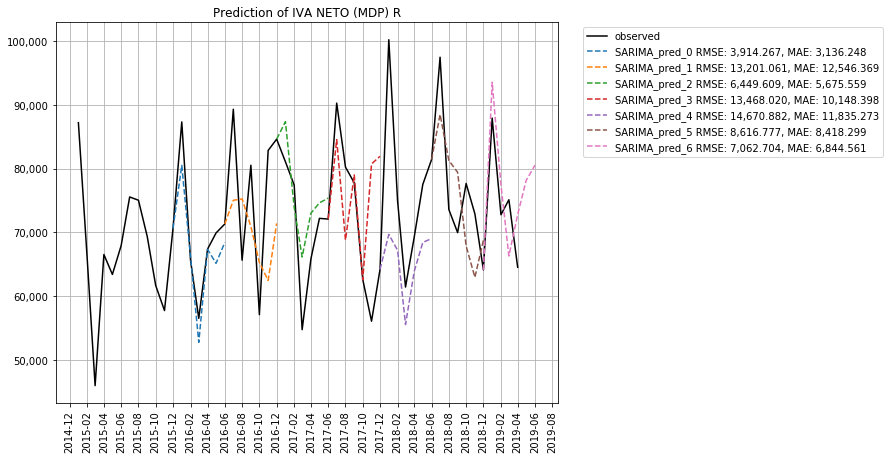

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 2), seasonal_order (1, 0, 1, 12), 


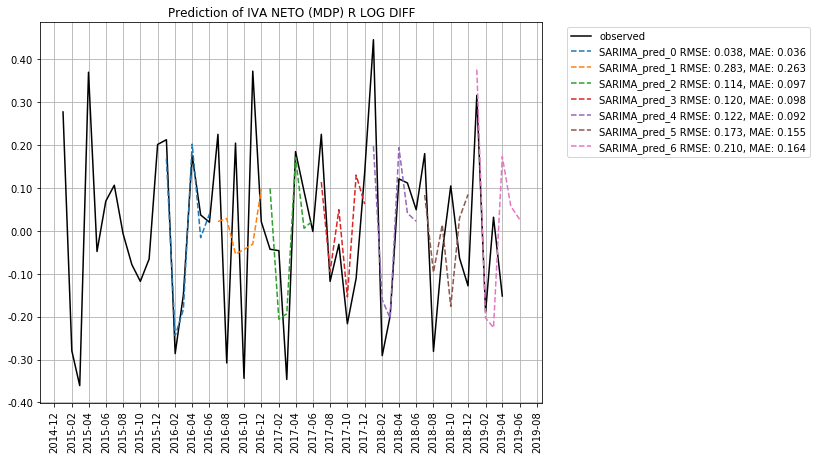

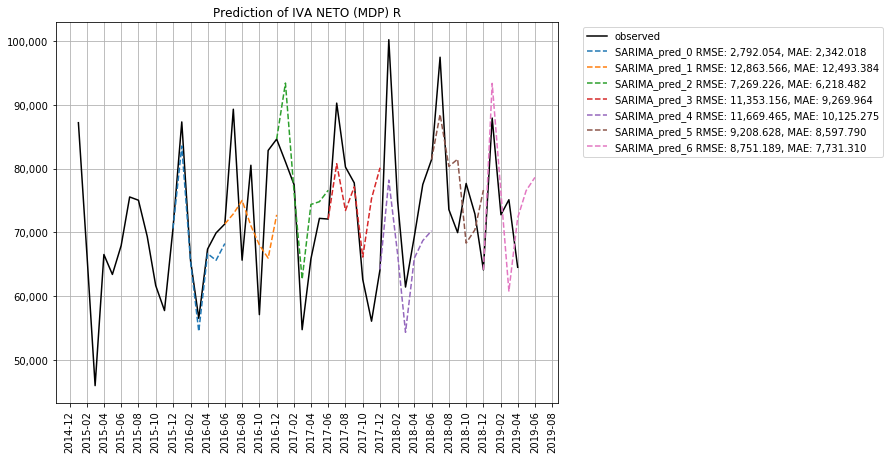

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 3), seasonal_order (0, 0, 0, 12), 


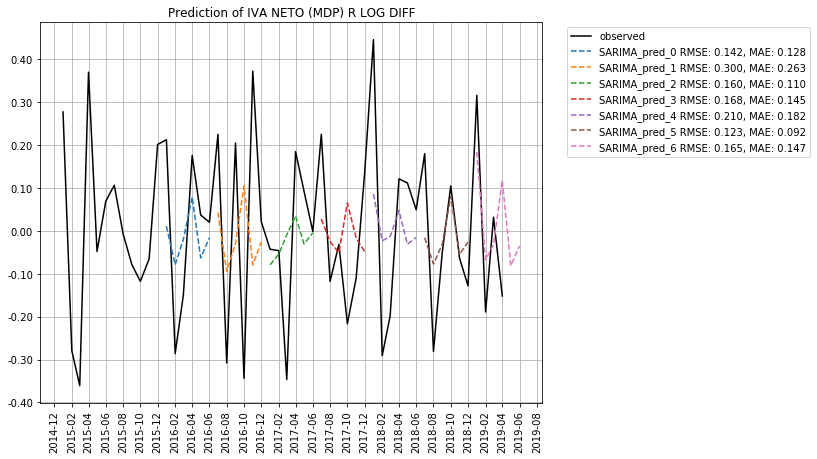

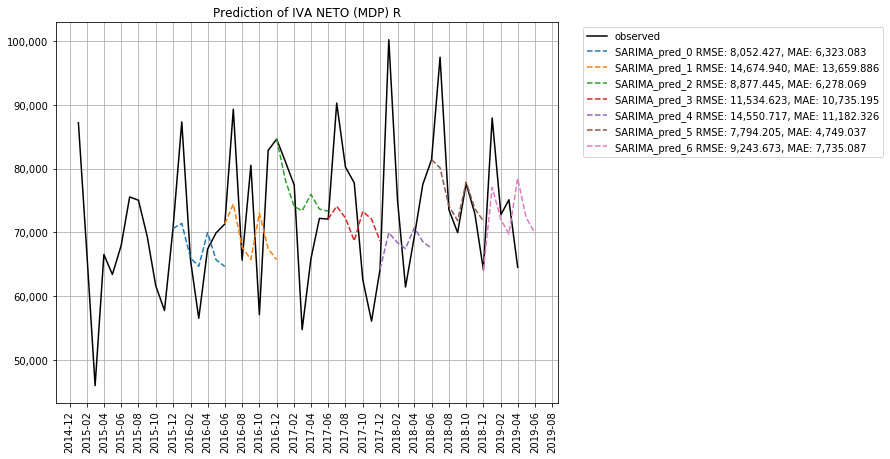

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 3), seasonal_order (0, 0, 1, 12), 


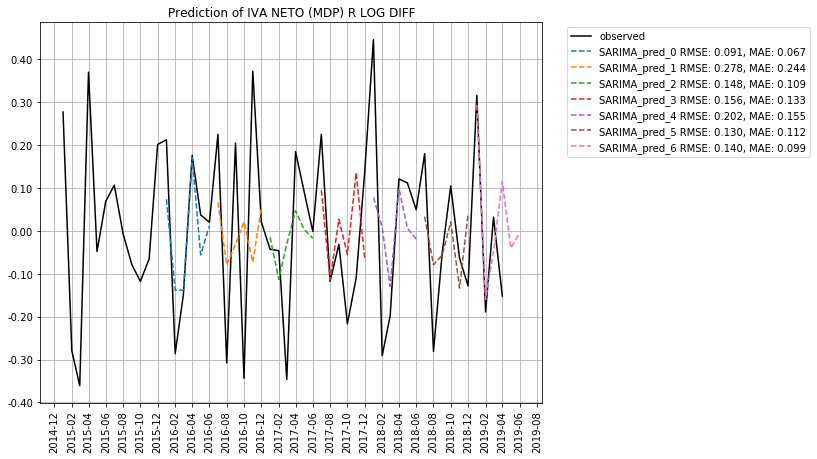

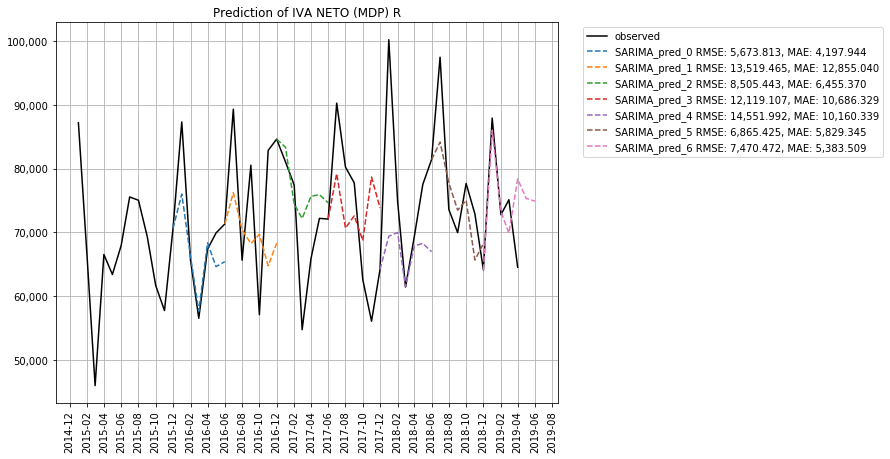

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 3), seasonal_order (1, 0, 0, 12), 


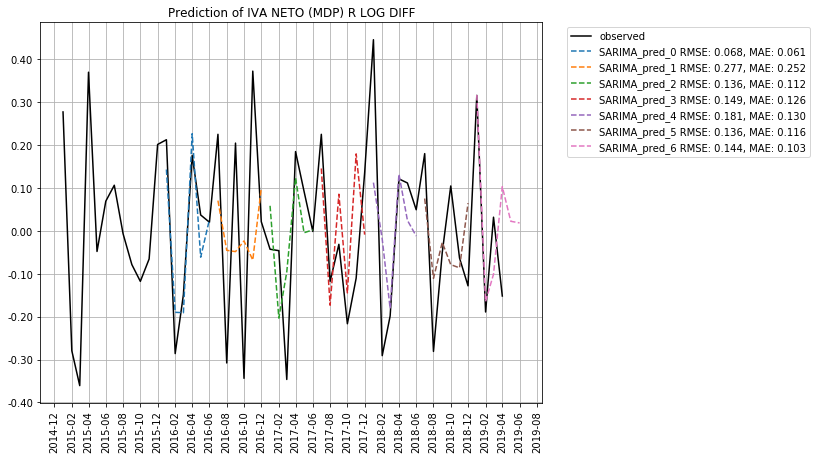

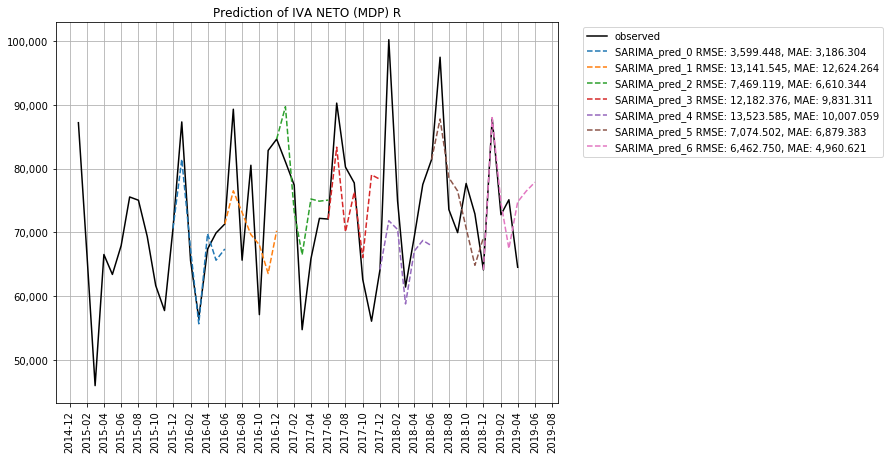

SARIMA: enforce_invertibility False, enforce_stationarity False, order (3, 0, 3), seasonal_order (1, 0, 1, 12), 


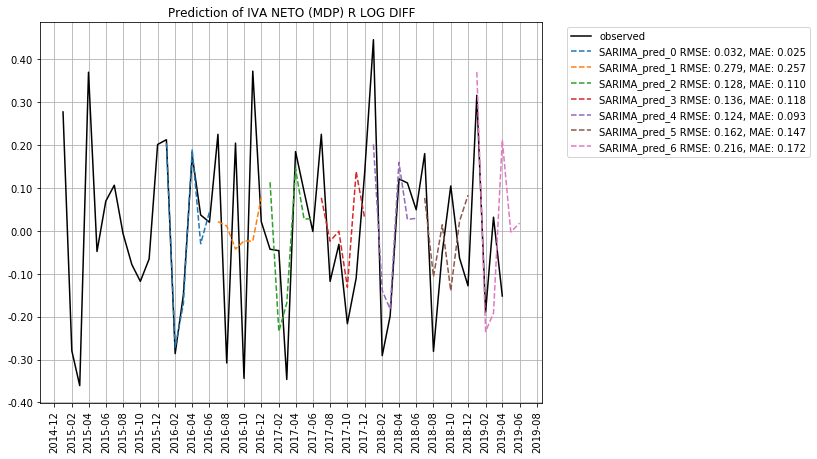

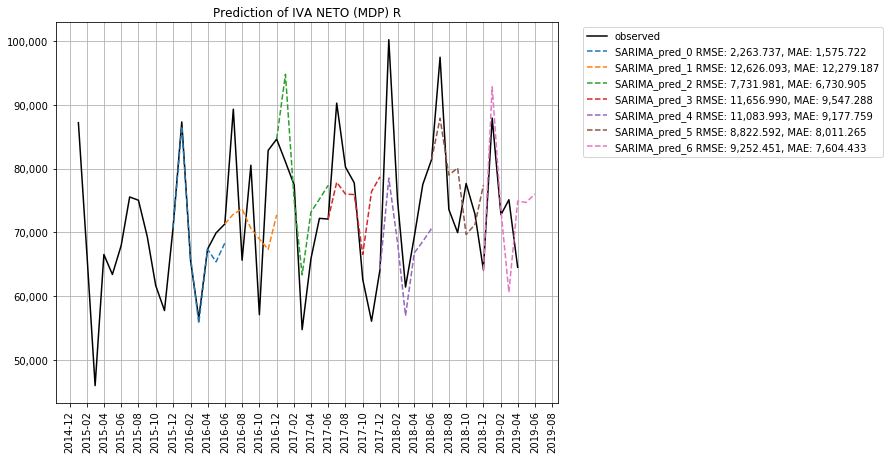

In [14]:
results_sarima = models.run_model_joint(model_name='SARIMA', all_models_params=all_models_params,
                                       outcome_var=outcome_ts, global_params=params, plot_extra=True,
                                       outcome_var_tr=outcome_ts_tr)

# Mechanical
Using PIB and elasticities

Hay diferencias entre datos de do file y estos datos. INPC es diferente. Recaudación y PIB son diferentes en los últimos valores

Las elasticidades de obtuvieron del promedio de elasticidades del último trimestre. (1.1 ISR y 1.3 IVA)

ELASTICITY: elasticity None, lag_window 3, 


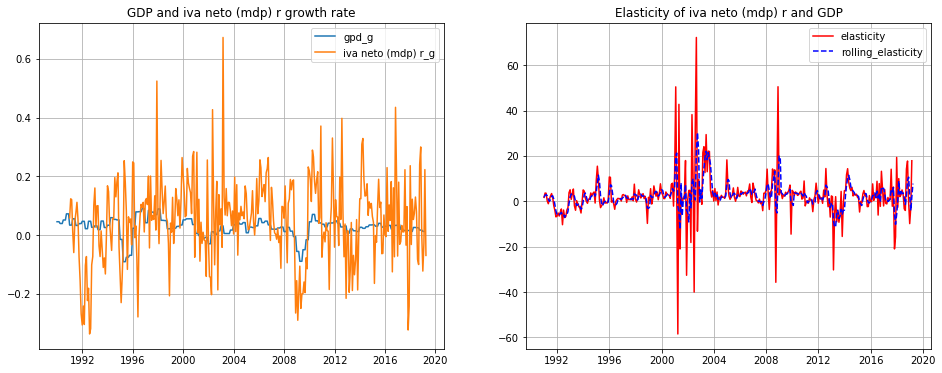

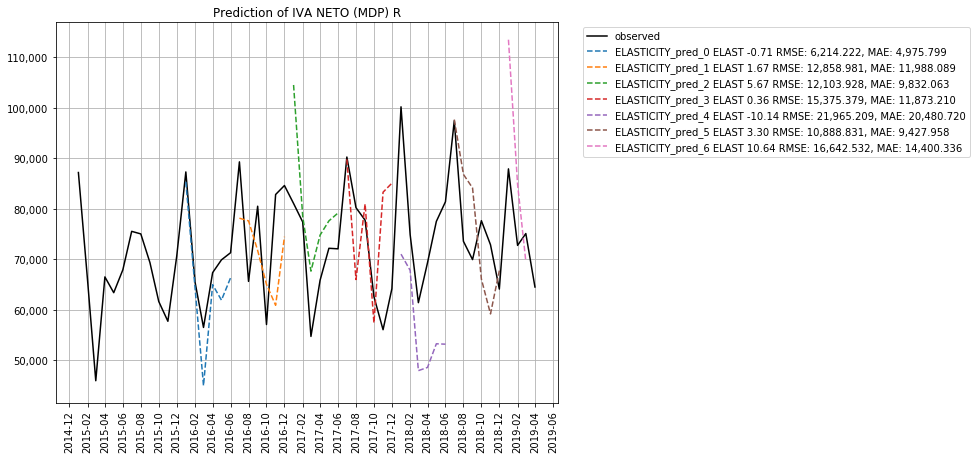

ELASTICITY: elasticity None, lag_window 6, 


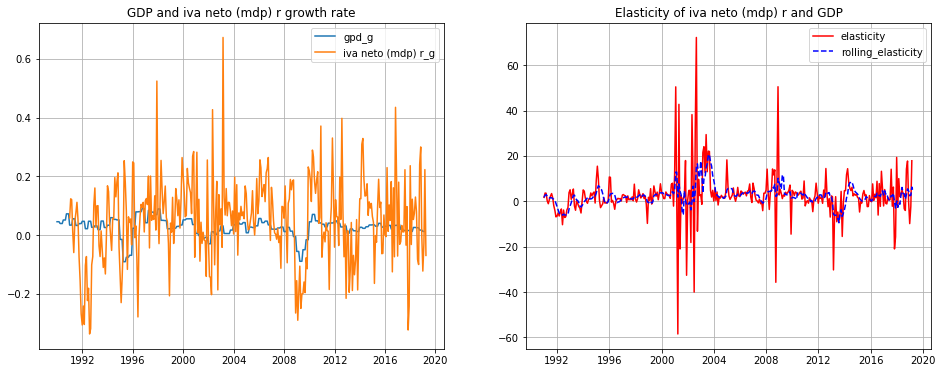

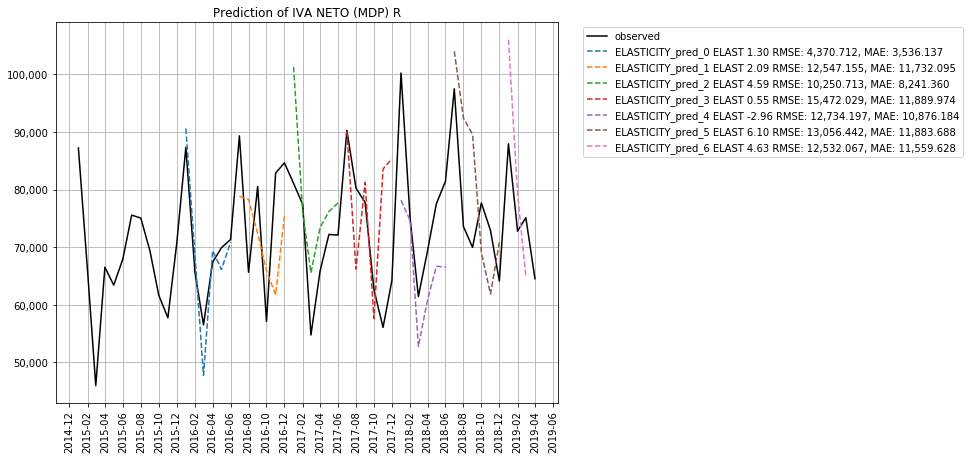

ELASTICITY: elasticity 1.3, lag_window 3, 


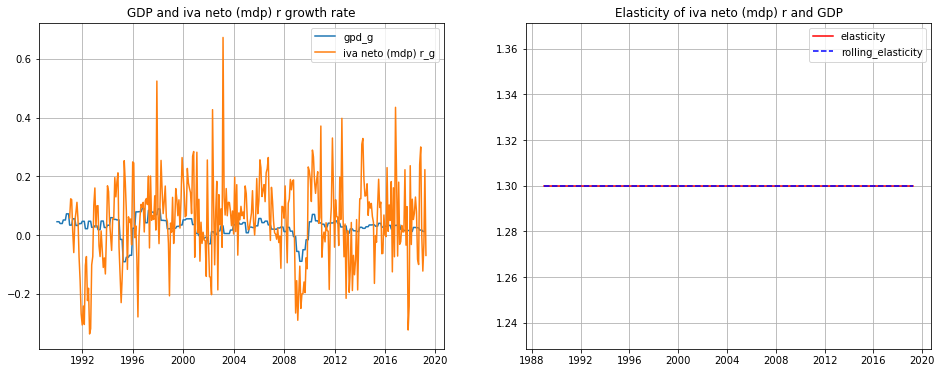

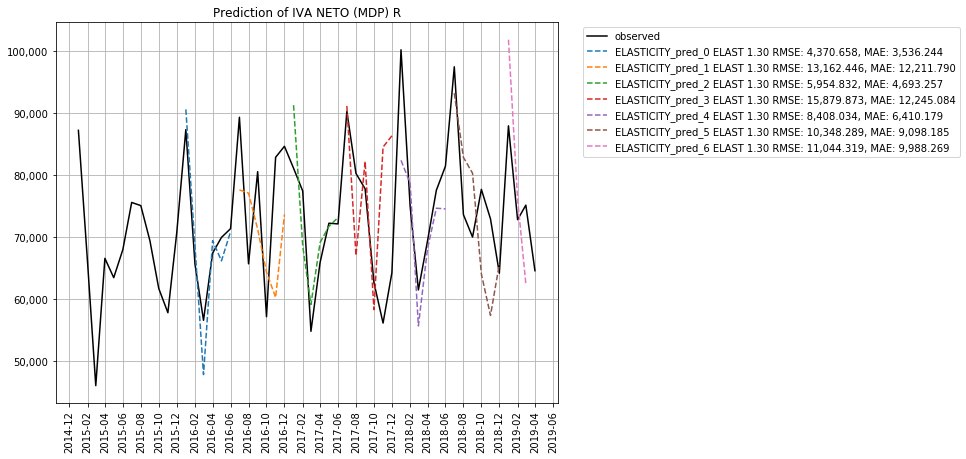

ELASTICITY: elasticity 1.3, lag_window 6, 


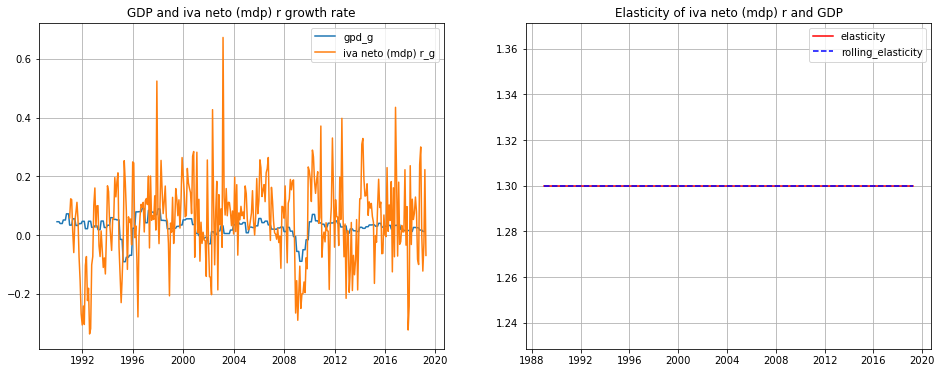

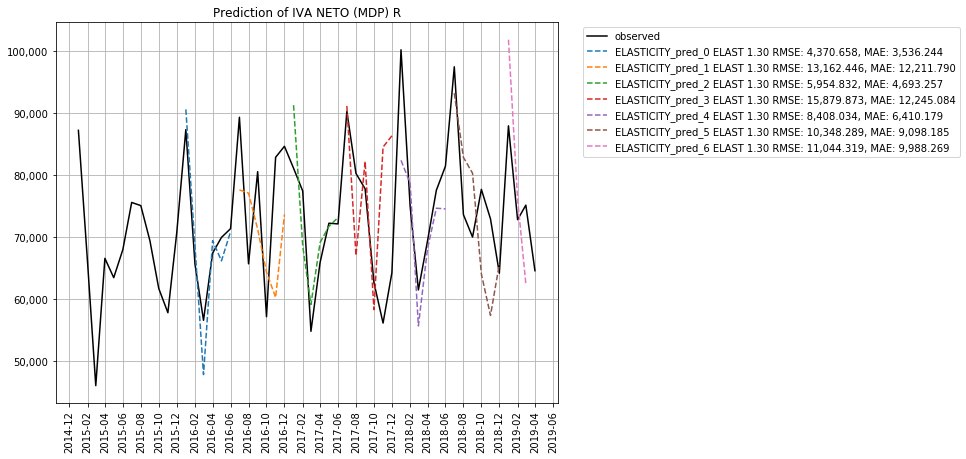

In [15]:
results_elasticity = models.run_model_joint(model_name='ELASTICITY', all_models_params=all_models_params,
                                            outcome_var=outcome_ts, global_params=params, plot_extra=True,
                                            covars=pib_r_2013)

# Facebook Prophet

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.


PROPHET: daily_seasonality False, seasonality_mode additive, weekly_seasonality False, 


INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.


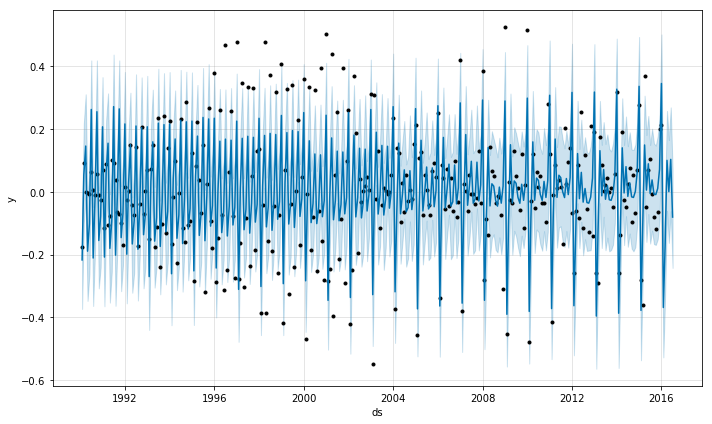

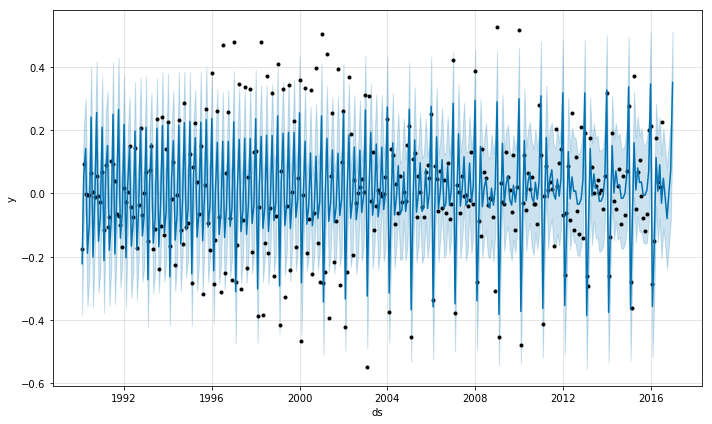

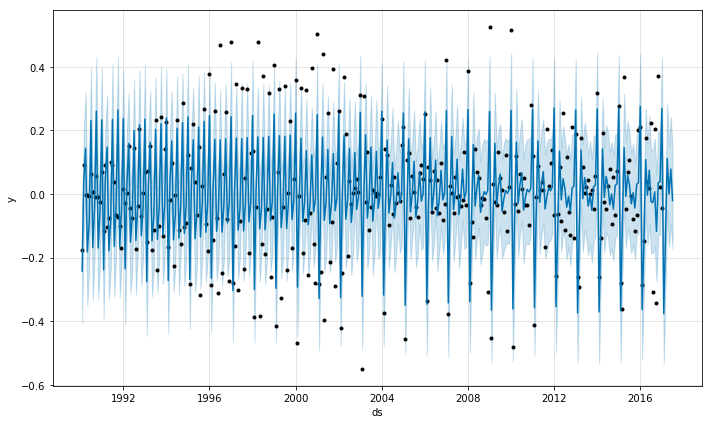

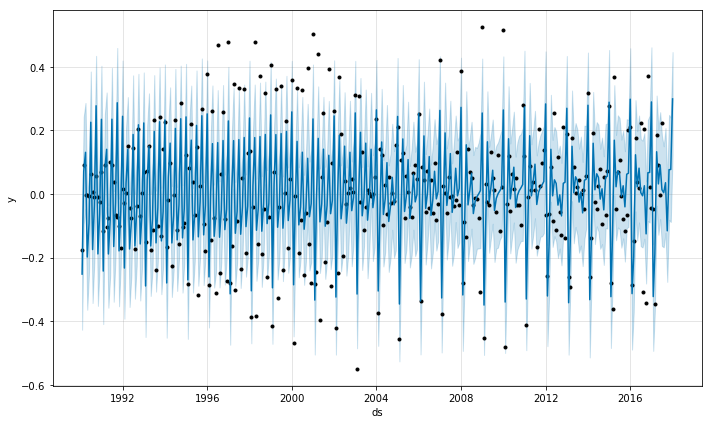

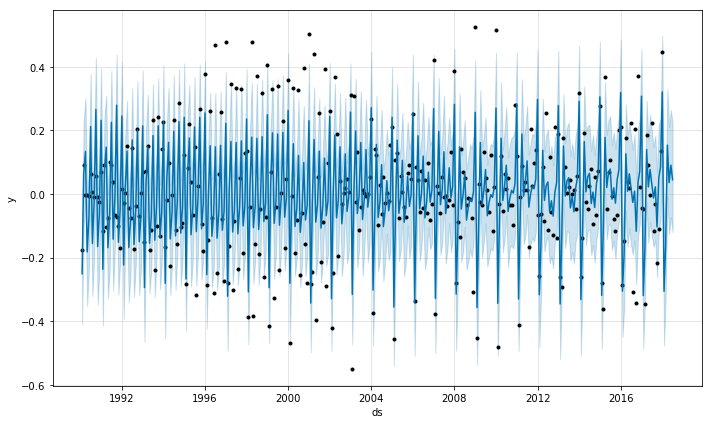

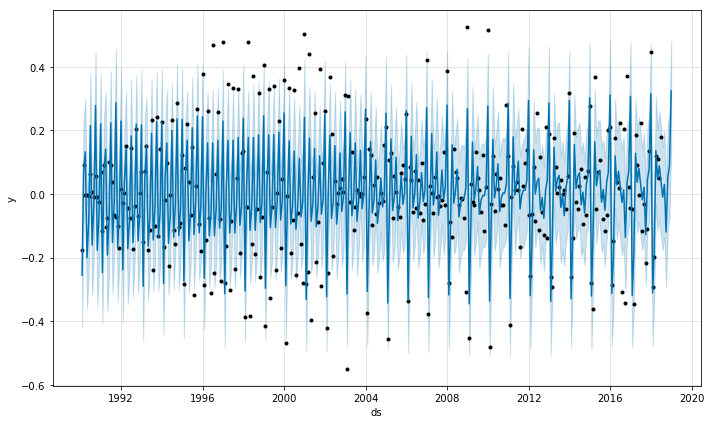

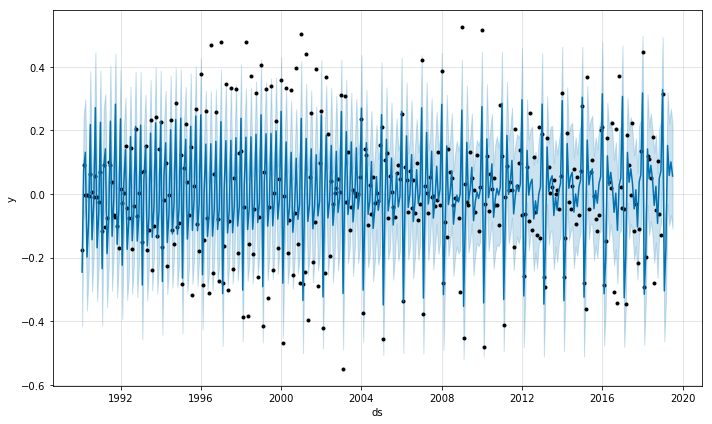

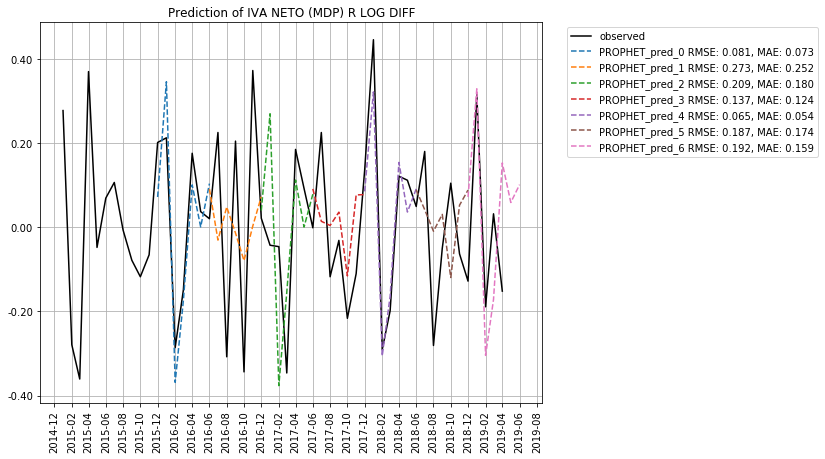

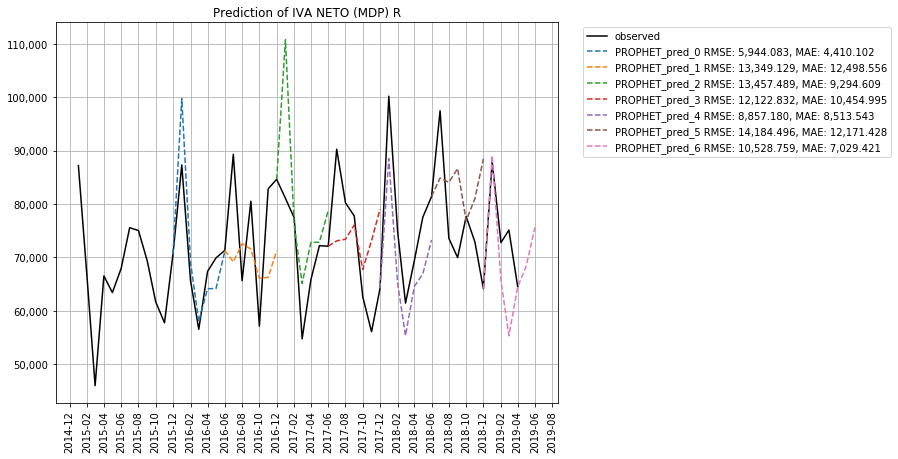

INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.


PROPHET: daily_seasonality False, seasonality_mode multiplicative, weekly_seasonality False, 


INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.


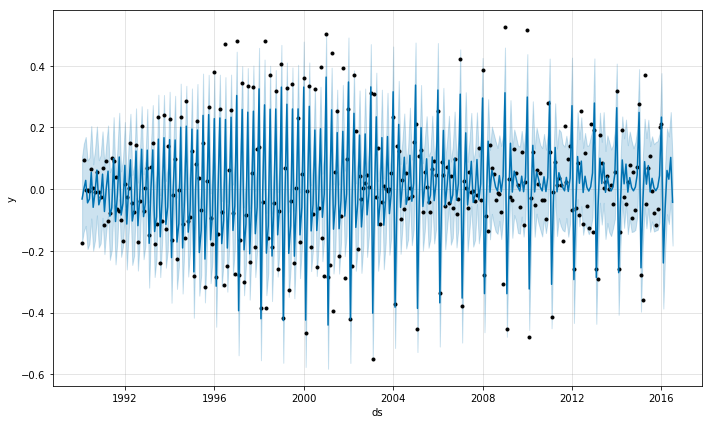

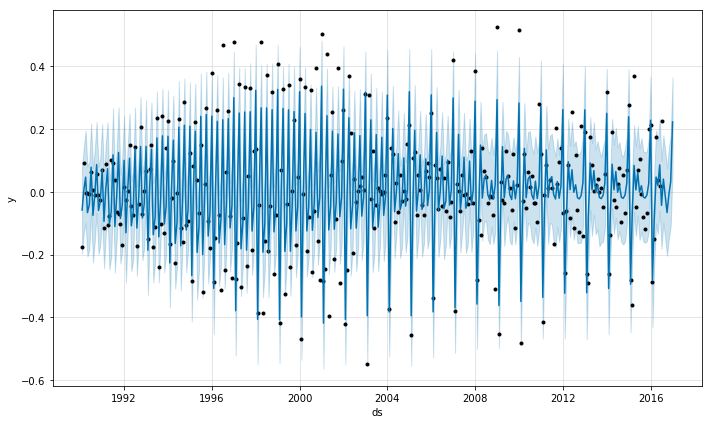

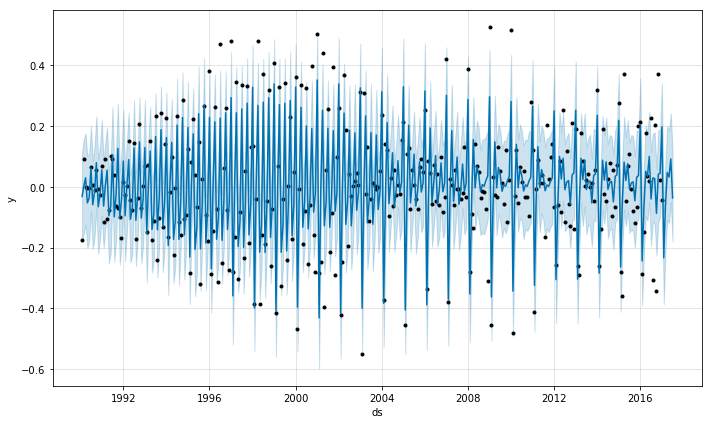

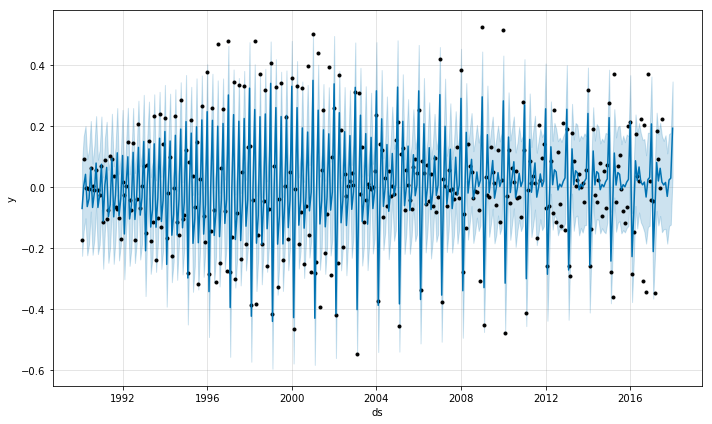

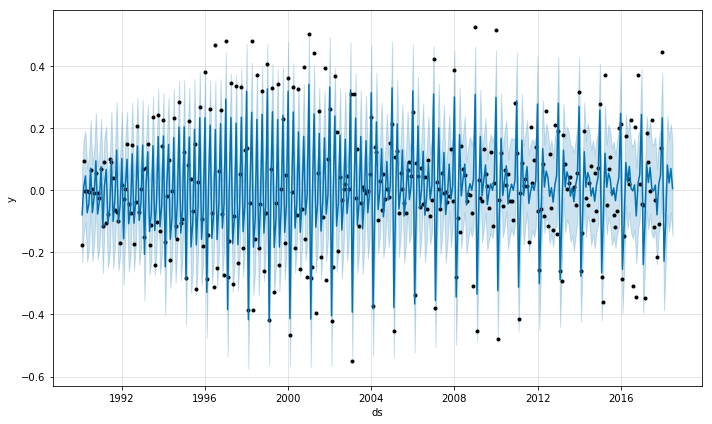

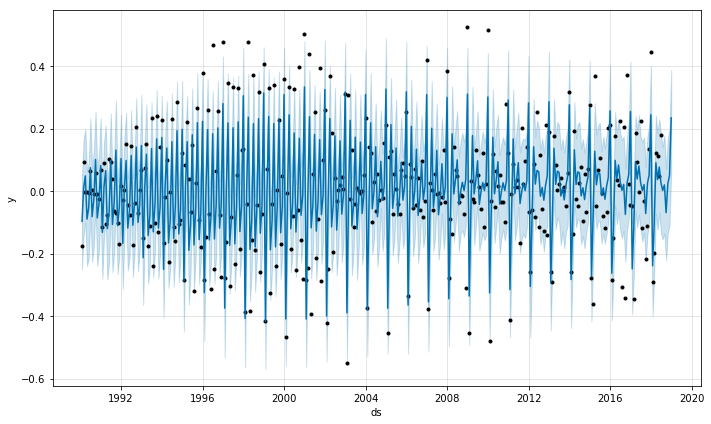

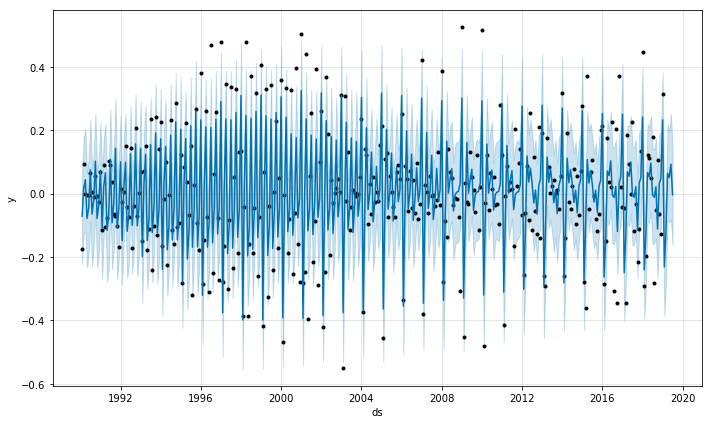

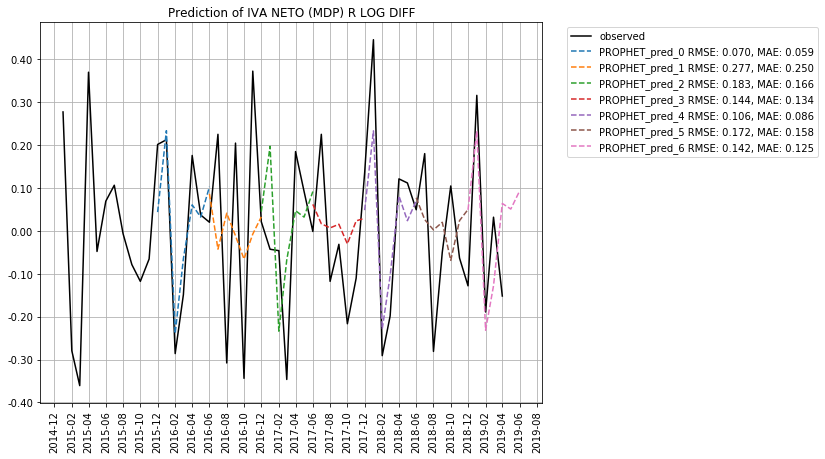

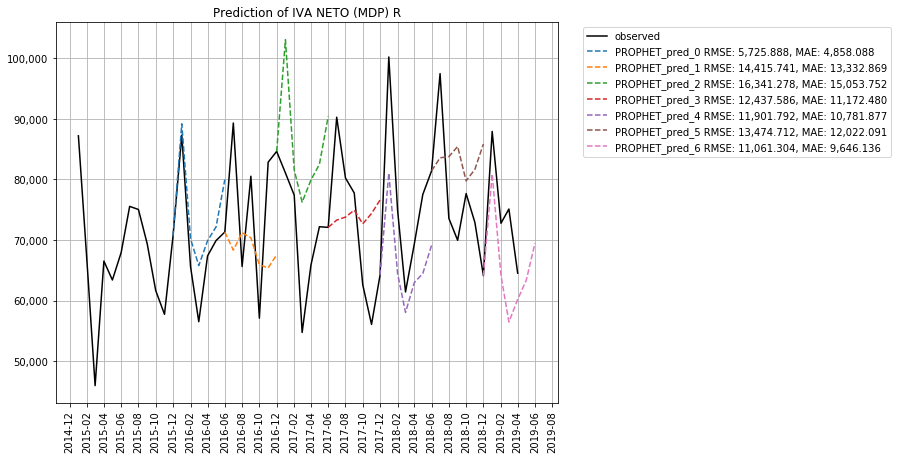

In [16]:
results_prophet = models.run_model_joint(model_name='PROPHET', all_models_params=all_models_params,
                                                outcome_var=outcome_ts, global_params=params, plot_extra=True,
                                                outcome_var_tr=outcome_ts_tr)

# Results Analysis

In [17]:
results_arima_df = pd.DataFrame(results_arima)
results_sarima_df = pd.DataFrame(results_sarima)
results_elasticity_df = pd.DataFrame(results_elasticity)
results_prophet_df = pd.DataFrame(results_prophet_w_seas)
results = pd.concat([results_arima_df, results_sarima_df, results_elasticity_df, results_prophet_df])
col_order = ['model', 'param', 'transformation', 'split_date', 'pred_period', 'dynamic', 'rmse', 'mae', 'mape', 'forecast_biass']
results = results[col_order]
results['param'] = results['param'].map(lambda x: str(x))

In [59]:
results

model                                              param  \
0        ARIMA                               {'order': (2, 0, 2)}   
1        ARIMA                               {'order': (2, 0, 2)}   
2        ARIMA                               {'order': (2, 0, 2)}   
3        ARIMA                               {'order': (2, 0, 2)}   
4        ARIMA                               {'order': (2, 0, 2)}   
5        ARIMA                               {'order': (2, 0, 2)}   
6        ARIMA                               {'order': (2, 0, 2)}   
7        ARIMA                               {'order': (2, 0, 2)}   
8        ARIMA                               {'order': (2, 0, 2)}   
9        ARIMA                               {'order': (2, 0, 2)}   
10       ARIMA                               {'order': (2, 0, 2)}   
11       ARIMA                               {'order': (2, 0, 2)}   
12       ARIMA                               {'order': (2, 0, 2)}   
13       ARIMA                               {'order': (2, 0, 2)}   
14       ARIMA                               {'order': (2, 0, 2)}   
15       ARIMA                               {'order': (2, 0, 3)}   
16       ARIMA                               {'order': (2, 0, 3)}   
17       ARIMA                               {'order': (2, 0, 3)}   
18       ARIMA                               {'order': (2, 0, 3)}   
19       ARIMA                               {'order': (2, 0, 3)}   
20       ARIMA                               {'order': (2, 0, 3)}   
21       ARIMA                               {'order': (2, 0, 3)}   
22       ARIMA                               {'order': (2, 0, 3)}   
23       ARIMA                               {'order': (2, 0, 3)}   
24       ARIMA                               {'order': (2, 0, 3)}   
25       ARIMA                               {'order': (2, 0, 3)}   
26       ARIMA                               {'order': (2, 0, 3)}   
27       ARIMA                               {'order': (2, 0, 3)}   
28       ARIMA                               {'order': (2, 0, 3)}   
29       ARIMA                               {'order': (2, 0, 3)}   
30       ARIMA                               {'order': (3, 0, 2)}   
31       ARIMA                               {'order': (3, 0, 2)}   
32       ARIMA                               {'order': (3, 0, 2)}   
33       ARIMA                               {'order': (3, 0, 2)}   
34       ARIMA                               {'order': (3, 0, 2)}   
35       ARIMA                               {'order': (3, 0, 2)}   
36       ARIMA                               {'order': (3, 0, 2)}   
37       ARIMA                               {'order': (3, 0, 2)}   
38       ARIMA                               {'order': (3, 0, 2)}   
39       ARIMA                               {'order': (3, 0, 2)}   
40       ARIMA                               {'order': (3, 0, 2)}   
41       ARIMA                               {'order': (3, 0, 2)}   
42       ARIMA                               {'order': (3, 0, 2)}   
43       ARIMA                               {'order': (3, 0, 2)}   
44       ARIMA                               {'order': (3, 0, 2)}   
45       ARIMA                               {'order': (3, 0, 3)}   
46       ARIMA                               {'order': (3, 0, 3)}   
47       ARIMA                               {'order': (3, 0, 3)}   
48       ARIMA                               {'order': (3, 0, 3)}   
49       ARIMA                               {'order': (3, 0, 3)}   
..         ...                                                ...   
6   ELASTICITY              {'elasticity': None, 'lag_window': 3}   
7   ELASTICITY              {'elasticity': None, 'lag_window': 6}   
8   ELASTICITY              {'elasticity': None, 'lag_window': 6}   
9   ELASTICITY              {'elasticity': None, 'lag_window': 6}   
10  ELASTICITY              {'elasticity': None, 'lag_window': 6}   
11  ELASTICITY              {'elasticity': None, 'lag_window': 6}   
12  ELA

In [32]:
results.loc[(results['split_date'] == '2016-01-01') & (results['model']=='SARIMA'), ['model', 'param', 'transformation','mape']].values

array([['SARIMA',
        "{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 2), 'seasonal_order': (0, 0, 0, 12)}",
        'log_diff', 1.015644664653076],
       ['SARIMA',
        "{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 2), 'seasonal_order': (0, 0, 0, 12)}",
        'levels', 0.10317813151346215],
       ['SARIMA',
        "{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 2), 'seasonal_order': (0, 0, 1, 12)}",
        'log_diff', 0.7211694547085051],
       ['SARIMA',
        "{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 2), 'seasonal_order': (0, 0, 1, 12)}",
        'levels', 0.07304613585876223],
       ['SARIMA',
        "{'enforce_invertibility': False, 'enforce_stationarity': False, 'order': (2, 0, 2), 'seasonal_order': (1, 0, 0, 12)}",
        'log_diff', 0.8742693211711439],
       ['SARIMA',
        "{'enforce_invertibility': False, 'enforce

In [48]:
results.loc[results['transformation']=='levels'].groupby(['model', 'param']).mean().sort_values('mape')

rmse  \
model      param                                                              
SARIMA     {'enforce_invertibility': False, 'enforce_stati...   9064.760552   
           {'enforce_invertibility': False, 'enforce_stati...   9062.548192   
           {'enforce_invertibility': False, 'enforce_stati...   9815.102534   
           {'enforce_invertibility': False, 'enforce_stati...   8994.512432   
           {'enforce_invertibility': False, 'enforce_stati...   9129.611945   
ELASTICITY {'elasticity': 1.3, 'lag_window': 3}                 9881.207381   
           {'elasticity': 1.3, 'lag_window': 6}                 9881.207381   
SARIMA     {'enforce_invertibility': False, 'enforce_stati...   9626.188743   
           {'enforce_invertibility': False, 'enforce_stati...   9656.327563   
           {'enforce_invertibility': False, 'enforce_stati...  10402.173874   
           {'enforce_invertibility': False, 'enforce_stati...   9631.099612   
           {'enforce_invertibility': False, 'enforce_stati...  10675.432898   
           {'enforce_invertibility': False, 'enforce_stati...  10625.587614   
           {'enforce_invertibility': False, 'enforce_stati...  10538.180686   
           {'enforce_invertibility': False, 'enforce_stati...  11017.219681   
           {'enforce_invertibility': False, 'enforce_stati...   9907.888065   
ARIMA      {'order': (3, 0, 3)}                                10637.625299   
           {'order': (2, 0, 2)}                                11347.386004   
           {'order': (2, 0, 3)}                                10920.182364   
SARIMA     {'enforce_invertibility': False, 'enforce_stati...  11660.605981   
PROPHET    {'daily_seasonality': False, 'seasonality_mode'...  11206.281178   
SARIMA     {'enforce_invertibility': False, 'enforce_stati...  11886.111317   
ARIMA      {'order': (3, 0, 2)}                                11666.749185   
ELASTICITY {'elasticity': None, 'lag_window': 6}               11566.187990   
PROPHET    {'daily_seasonality': False, 'seasonality_mode'...  12194.043105   
ELASTICITY {'elasticity': None, 'lag_window': 3}               13721.297366   

                                                                        mae  \
model      param                                                              
SARIMA     {'enforce_invertibility': False, 'enforce_stati...   7728.469470   
           {'enforce_invertibility': False, 'enforce_stati...   7846.651421   
           {'enforce_invertibility': False, 'enforce_stati...   7938.267936   
           {'enforce_invertibility': False, 'enforce_stati...   8024.293071   
           {'enforce_invertibility': False, 'enforce_stati...   8111.174556   
ELASTICITY {'elasticity': 1.3, 'lag_window': 3}                 8311.858160   
           {'elasticity': 1.3, 'lag_window': 6}                 8311.858160   
SARIMA     {'enforce_invertibility': False, 'enforce_stati...   8372.100877   
           {'enforce_invertibility': False, 'enforce_stati...   8382.428233   
           {'enforce_invertibility': False, 'enforce_stati...   8578.270893   
           {'enforce_invertibility': False, 'enforce_stati...   8535.747679   
           {'enforce_invertibility': False, 'enforce_stati...   8666.097487   
           {'enforce_invertibility': False, 'enforce_stati...   8874.619380   
           {'enforce_invertibility': False, 'enforce_stati...   8898.238187   
           {'enforce_invertibility': False, 'enforce_stati...   8919.847751   
           {'enforce_invertibility': False, 'enforce_stati...   8805.472691   
ARIMA      {'order': (3, 0, 3)}                                 8802.223005   
           {'order': (2, 0, 2)}                                 9176.471630   
           {'order': (2, 0, 3)}                                 9060.969616   
SARIMA     {'enforce_invertibility': False, 'enforce_stati...   9395.292759   
PROPHET    {'daily_seasonality': False, 'seasonality_mode'...   9196.093416   
SARIMA     {'enforce_invertibility': Fals

In [19]:
results_log_diff = results.loc[(results['split_date'].notna()) & (results['transformation'] == 'log_diff')]

In [20]:
results_levels = results.loc[(results['split_date'].notna()) & (results['transformation'] == 'levels')]

In [56]:
summary_levels = pd.pivot_table(results_levels,
                                 index=['model', 'split_date'],
                                 aggfunc='min',
                                 fill_value=0)
summary_levels = summary_levels.reset_index()

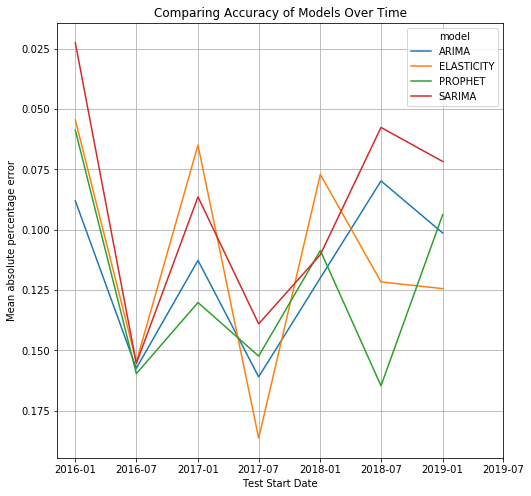

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x="split_date", y="mape", hue='model',
             data=summary_levels, ax=ax)
ax.invert_yaxis()
ax.set_xlabel("Test Start Date")
ax.set_ylabel("Mean absolute percentage error")
ax.set_title("Comparing Accuracy of Models Over Time")
ax.set_xticks(pd.date_range(params['pred_start'], params['pred_end'], freq='6MS'))
ax.grid()
plt.show()

# Decision Trees

In [118]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression

In [119]:
X_tr = outcome_ts_tr.shift(1).rename('lag1').to_frame()
for lag in [1, 2, 3, 12]:
    X['lag{}'.format(lag)] = outcome_ts_tr.shift(lag)
X_tr = X.loc[X.notna().all(1)]
y_tr = outcome_ts_tr.loc[X.index]

In [123]:
X_tr_train = X.loc[X.index<'2017-01-01']
y_tr_train = y.loc[y.index<'2017-01-01']
X_tr_test = X.loc[pd.date_range('2017-01-01', '2017-12-01', freq='MS')]
y_tr_test = y.loc[pd.date_range('2017-01-01', '2017-12-01', freq='MS')]

In [124]:
regr = DecisionTreeRegressor()

In [125]:
regr.fit(X_tr_train, y_tr_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [126]:
y_tr_pred = regr.predict(X_test)
y_tr_pred = pd.Series(y_pred, index=pd.date_range('2017-01-01', '2017-12-01', freq='MS'))

In [127]:
regr.feature_importances_

array([0.3275758 , 0.08066008, 0.12554342, 0.4662207 ])

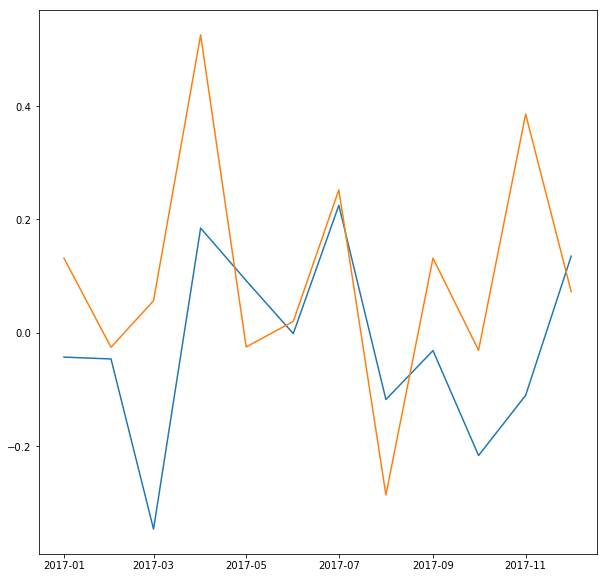

In [134]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y_tr_test)
ax.plot(y_tr_pred)
plt.show()

In [137]:
y_tr_pred

2017-01-01    0.131669
2017-02-01   -0.025625
2017-03-01    0.056582
2017-04-01    0.525520
2017-05-01   -0.024988
2017-06-01    0.019996
2017-07-01    0.252243
2017-08-01   -0.286078
2017-09-01    0.131669
2017-10-01   -0.030936
2017-11-01    0.385725
2017-12-01    0.072549
Freq: MS, dtype: float64

In [138]:
y_pred

2016-12-01     84632.863503
2017-01-01     96543.316787
2017-02-01     94100.823679
2017-03-01     99578.799140
2017-04-01    168421.455748
2017-05-01    164265.008888
2017-06-01    167582.717131
2017-07-01    215663.763909
2017-08-01    162007.564546
2017-09-01    184807.023874
2017-10-01    179177.448798
2017-11-01    263512.691358
2017-12-01    283340.851688
dtype: float64

In [129]:
models.compute_accuracy_scores(y_test, y_pred, True)

{'rmse': 0.23518158506956383,
 'mae': 0.1817177286982344,
 'mape': 2.9707216504315563,
 'forecast_biass': -0.12371907317341317}

In [130]:
initial_vale = outcome_ts['2016-12-01']
y_pred = descriptive.revert_transformation(y_tr_pred, 'log_diff', initial_vale, '2016-12-01')

In [131]:
models.compute_accuracy_scores(outcome_ts, y_pred, True)

{'rmse': 114064.08987841672,
 'mae': 94184.76104025164,
 'mape': 1.395329134188972,
 'forecast_biass': -94184.76104025164}

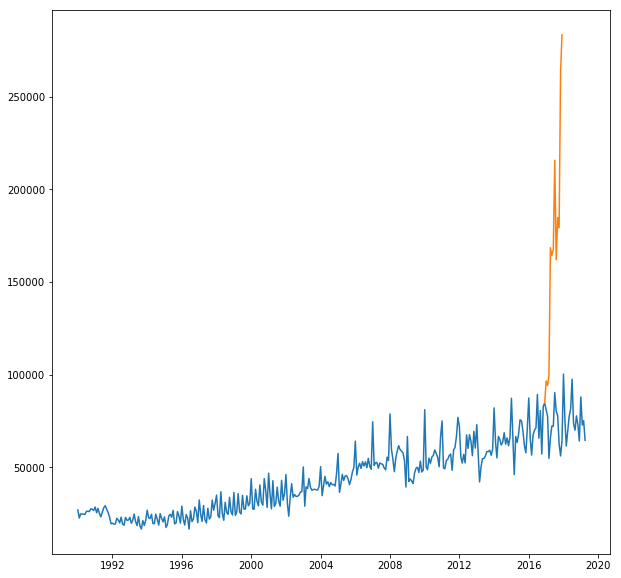

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(outcome_ts)
ax.plot(y_pred)
plt.show()

In [139]:
pib_r_2013

fecha
1989-01-01    8.575114e+06
1989-02-01    8.575114e+06
1989-03-01    8.575114e+06
1989-04-01    8.912466e+06
1989-05-01    8.912466e+06
1989-06-01    8.912466e+06
1989-07-01    8.452557e+06
1989-08-01    8.452557e+06
1989-09-01    8.452557e+06
1989-10-01    8.881445e+06
1989-11-01    8.881445e+06
1989-12-01    8.881445e+06
1990-01-01    8.964420e+06
1990-02-01    8.964420e+06
1990-03-01    8.964420e+06
1990-04-01    9.262516e+06
1990-05-01    9.262516e+06
1990-06-01    9.262516e+06
1990-07-01    8.885512e+06
1990-08-01    8.885512e+06
1990-09-01    8.885512e+06
1990-10-01    9.522793e+06
1990-11-01    9.522793e+06
1990-12-01    9.522793e+06
1991-01-01    9.268190e+06
1991-02-01    9.268190e+06
1991-03-01    9.268190e+06
1991-04-01    9.775235e+06
1991-05-01    9.775235e+06
1991-06-01    9.775235e+06
1991-07-01    9.176389e+06
1991-08-01    9.176389e+06
1991-09-01    9.176389e+06
1991-10-01    9.894609e+06
1991-11-01    9.894609e+06
1991-12-01    9.894609e+06
1992-01-01    9.701986

In [140]:
fiscal_income_df['']

fecha
1989-01-01         NaN
1989-02-01         NaN
1989-03-01         NaN
1989-04-01         NaN
1989-05-01         NaN
1989-06-01         NaN
1989-07-01         NaN
1989-08-01         NaN
1989-09-01         NaN
1989-10-01         NaN
1989-11-01         NaN
1989-12-01         NaN
1990-01-01    0.003002
1990-02-01    0.002520
1990-03-01    0.002765
1990-04-01    0.002671
1990-05-01    0.002661
1990-06-01    0.002647
1990-07-01    0.002942
1990-08-01    0.002957
1990-09-01    0.002928
1990-10-01    0.002891
1990-11-01    0.002867
1990-12-01    0.002793
1991-01-01    0.003074
1991-02-01    0.002738
1991-03-01    0.002996
1991-04-01    0.002558
1991-05-01    0.002371
1991-06-01    0.002624
1991-07-01    0.003064
1991-08-01    0.003182
1991-09-01    0.002983
1991-10-01    0.002576
1991-11-01    0.002329
1991-12-01    0.001967
1992-01-01    0.002038
1992-02-01    0.001984
1992-03-01    0.001991
1992-04-01    0.002247
1992-05-01    0.002151
1992-06-01    0.001996
1992-07-01    0.002397
1992-